# trasformare gli opendata di RNA in Parquet

In [1]:
import pandas as pd
import os
import csv
from datetime import datetime
import dateutil.parser as parser
import glob
# Change the working directory and read the xml file
os.chdir("D:/duckdb")

import lxml.etree as ET
#using lxml instead of xml preserved the comments

# pip install pyarrow

In [2]:
%%time

mese ='2023_12'
file = 'OpenData_Aiuti_' + mese + '.xml'

#adding the encoding when the file is opened and written is needed to avoid a charmap error
with open('C:/Users/paolo/Downloads/'+file, encoding="utf8") as f: # 
  tree = ET.parse(f)
  root = tree.getroot()

os.chdir('D:/duckdb')

for elem in root.getiterator():
    try:
      #elem.text = elem.text.replace('&#2;', '')
      elem.text = elem.text.replace('&#13;', '')
      elem.text = elem.text.replace('&#16;', '')
      elem.text = elem.text.replace('&#157;', '')
      elem.text = elem.text.replace('|', '')
      elem.text = elem.text.replace('\n', '')
      elem.text = elem.text.replace('URA>', 'URA')
      elem.text = elem.text.replace('RIO>', 'RIO')
    except AttributeError:
      pass

# https://stackoverflow.com/questions/37868881/how-to-search-and-replace-text-in-an-xml-file-using-python

#tree.write('output.xml', encoding="utf8")
# Adding the xml_declaration and method helped keep the header info at the top of the file.
tree.write(file, xml_declaration=True, method='xml', encoding="utf8")

# usare xml2csv su windows
!xml2csv OpenData_Aiuti_2023_12.xml OpenData_Aiuti_2023_12.csv template.txt -D=\#124  usare xml2csv su windows

# convertire il csv in parquet
file = 'OpenData_Aiuti_' + mese + '.csv'
df = pd.read_csv(file, sep='|', encoding='latin1', on_bad_lines='skip', quoting=csv.QUOTE_NONE)
df['DATA_CONCESSIONE'] = df['DATA_CONCESSIONE'].str[:10]
df['DATA_CONCESSIONE']= pd.to_datetime(df['DATA_CONCESSIONE'])

# df.to_csv('RNA'+mese+'.csv', sep='|')

df.to_parquet('D:/duckdb/files/RNA/aiuti/parquet/'+'RNA' + mese + '.parquet')

"A7Soft xml2csv 5.33" - xml to csv converter
CPU times: total: 11.8 s
Wall time: 1min 22s


## 4) inserire il parquet nel DB

vedi anche FDG2Parquet

In [ ]:
import duckdb
os.chdir('D:/duckdb')
conn = duckdb.connect('rna.duckdb')

In [ ]:
conn.execute(f'''select count(*) from rna;''').df()

In [ ]:
conn.execute(f'''select year(data_concessione) anno ,  month(data_concessione) mese, 
count(*) aiuti from RNA group by year(data_concessione), month(data_concessione) order by anno desc, mese desc;''').df()

In [ ]:
conn.execute(f'''
DELETE FROM rna WHERE year(data_concessione) = 2023 and month(data_concessione) = 11; 
''').df()

In [ ]:
conn.execute(f''' ;
INSERT INTO RNA SELECT * FROM read_parquet('D:\\duckdb\\files\\RNA\\aiuti\\parquet\\RNA2023_11.parquet');
''').df()

## cancellare tutte le linee del FdG

In [ ]:
conn.execute(f'''
DELETE FROM rna WHERE CAR in (24793,23546,24646,526,16615,18730,16617,15884,12627,27308,16617);
''').df()

# lanciare lo script opendata.ipynb

## Queries varie sui CAR

## 5) interrogare i parquet ( e non il DB)

In [ ]:
import duckdb
conn = duckdb.connect("RNA.duckdb") # ,read_only=False

In [ ]:
conn.execute(f'''
select month(data_concessione) mese,
count(CAR) filter(where year(data_concessione)=2018) "2018",
count(CAR) filter(where year(data_concessione)=2019) "2019",
count(CAR) filter(where year(data_concessione)=2020) "2020",
count(CAR) filter(where year(data_concessione)=2021) "2021",
count(CAR) filter(where year(data_concessione)=2022) "2022",
count(CAR) filter(where year(data_concessione)=2023) "2023" 
from 
(select *, extract(month from data_concessione) mese, extract(year from data_concessione) anno 
from read_parquet('D:/Duckdb/files/RNA/aiuti/parquet/*.parquet')) aiuti 
group by month(data_concessione);''').df()

In [ ]:
aiuti = conn.execute(f'''select CAR, trim(TITOLO_MISURA) misura, max(DATA_CONCESSIONE) recente, 
count(distinct(CODICE_FISCALE_BENEFICIARIO)) imprese 
from read_parquet('D:/Duckdb/files/RNA/aiuti/parquet/*.parquet')
group by 1,2
order by 3 desc''').df()

aiuti.tail(50)

In [ ]:
agevolazioni = conn.execute(f'''select CODICE_FISCALE_BENEFICIARIO impresa , count(distinct(CAR)) agevolazioni,count((CAR)), sum(ELEMENTO_DI_AIUTO) from read_parquet('D:/Duckdb/files/RNA/aiuti/parquet/*.parquet')
group by 1
order by 2 desc
limit 20''').df()

agevolazioni

In [ ]:
impresaX = conn.execute(f'''select 
left (SOGGETTO_CONCEDENTE,50) concedente,trim(left((TITOLO_MISURA),30)) misura ,year(DATA_CONCESSIONE) anno,
IMPORTO_NOMINALE
 from read_parquet('D:/Duckdb/files/RNA/aiuti/parquet/*.parquet') 
 where CODICE_FISCALE_BENEFICIARIO = '11587171007' 
 order by DATA_CONCESSIONE desc;''').df()
print(impresaX.to_markdown(index=False))

In [ ]:
print(df.to_markdown(index=False)) # print(df.head(10).to_markdown(index=False))

## analisi con PyArrow

In [ ]:
import pyarrow.parquet as pq
import pandas as pd
import glob
import duckdb
import os
os.chdir('D:/duckdb/files/RNA/aiuti/parquet/')
 
con = duckdb.connect()
con.execute("PRAGMA threads=2") # enable automatic query parallelization
con.execute("PRAGMA enable_object_cache") # enable caching of parquet metadata

In [ ]:
%%time
print(con.execute("SELECT COUNT(*) FROM 'RNA*.parquet'").df())

In [ ]:
print(con.execute("select year(data_concessione) anno, month(data_concessione) mese, day(data_concessione) giorno, \
                  count(*) aiuti FROM '*.parquet' \
                  where year(data_concessione) =2023  and month(data_concessione) =11 \
                  group by year(data_concessione), month(data_concessione), day (data_concessione) \
                  order by anno desc, mese desc, giorno desc;").df())

## verifica su codici fiscali

In [ ]:
(con.execute("select titolo_misura misura, SOGGETTO_CONCEDENTE concedente,\
DATA_CONCESSIONE concessione,DENOMINAZIONE_BENEFICIARIO impresa ,IMPORTO_NOMINALE FROM '*.parquet' \
where CODICE_FISCALE_BENEFICIARIO in ('01952970513')\
order by 4;").df())

In [ ]:
df.to_csv('D:/GruppoMoretti.csv', sep='\t')

## Nuova Sabatini

In [ ]:
df =(con.execute("SELECT year(data_concessione) anno, month(data_concessione) mese, count(distinct(CODICE_FISCALE_BENEFICIARIO)) imprese, \
cast(sum(importo_nominale)/1000000 as decimal(10,0)) tot_M€ FROM '*.parquet' where CAR = 203 group by 1,2 order by 1 desc,2 desc").df())

df

In [ ]:
df.pivot_table( ['anno','mese'], index =['imprese','tot_M€'], fill_value=0)

In [ ]:
df =(con.execute("SELECT data_concessione delibera, codice_fiscale_beneficiario CF, denominazione_beneficiario impresa, \
importo_nominale finanziamento, elemento_di_aiuto aiuto  FROM '*.parquet' where CAR = 203 and finanziamento > 0 order by finanziamento desc;").df())

df.to_csv('D:/NuovaSabatini.csv', index = False)

## SME Initiative 3656

In [ ]:
pd.options.display.float_format = '{:.0f}'.format #suppress scientific notation
df = (con.execute("SELECT year(data_concessione) anno, soggetto_concedente banca, \
count(distinct(CODICE_FISCALE_BENEFICIARIO)) imprese, \
sum(importo_nominale)/1000000 importo_M€ \
FROM '*.parquet' where CAR = 3656 group by 1,2 order by 1 desc, 2").df())
df

In [ ]:
df =(con.execute("SELECT year(data_concessione) anno, soggetto_concedente banca, \
count(distinct(CODICE_FISCALE_BENEFICIARIO)) imprese, \
sum(importo_nominale)/1000000 importo \
FROM '*.parquet' where CAR = 3656 group by 1,2 order by 1 desc, 2").df())


In [ ]:
pd.pivot_table( df, columns =['anno'], index ='banca', fill_value=0,  
               aggfunc={'imprese':'sum', 'importo':'sum'},margins=True).round(0)

In [ ]:
df= (con.execute("SELECT year(data_concessione) anno, soggetto_concedente banca, denominazione_beneficiario impresa, \
                 importo_nominale importo FROM '*.parquet' where CAR = 3656").df())
df

In [ ]:
print(con.execute("SELECT * FROM '*.parquet' limit 2").df())

In [ ]:

pd.set_option('display.max_column', None)

In [ ]:
con.execute("select distinct(denominazione_beneficiario) impresa, importo_nominale/1000 from '*.parquet'\
where car in (24682) and year(data_concessione) =2023 and month(data_concessione) = 2 order by 2 desc;").df()

In [ ]:
con.execute("select count(denominazione_beneficiario), sum(importo_nominale/1000) from '*.parquet' \
where car in (24682) and year(data_concessione) =2023 and month(data_concessione) = 2").df()

## Finlombarda

In [ ]:
df = (con.execute("select left(trim(titolo_misura),50) AdS , count(distinct(codice_fiscale_beneficiario)) imprese \
from  '*.parquet'  where upper(soggetto_concedente) like upper('%Finlombarda%') group by 1").df())
print(df.to_markdown())

## ISMEA

In [ ]:
df = (con.execute("select (trim(titolo_misura)) AdS , count(distinct(codice_fiscale_beneficiario)) imprese \
from  '*.parquet'  where upper(soggetto_concedente) like upper('%ISMEA%') group by 1").df())
print(df)

In [ ]:
Ismea = (con.execute("select * from  '*.parquet'  where upper(soggetto_concedente) like upper('%ISMEA%') and year(data_concessione)=2023").df())

In [ ]:
Rna_Ismea_CF = (con.execute("select distinct(codice_fiscale_beneficiario) CF \
from  '*.parquet'  where upper(soggetto_concedente) like upper('%ISMEA%');").df())

In [ ]:
Rna_Ismea_CF.count()

In [ ]:
Rna_Ismea_CF.to_csv('D:/Rna_Ismea_CF.csv', index=False)

In [ ]:
Ismea.to_csv('D:/Ismea.csv', index=False)


## [Fondo di Garanzia](https://www.fondidigaranzia.it/)

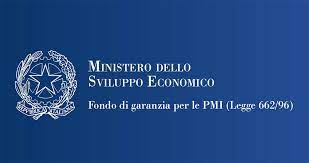

In [ ]:
pd.set_option('display.max_rows', None)
df =(con.execute("select CAR, titolo_misura,soggetto_concedente from  '*.parquet'  where upper(soggetto_concedente) like upper('%banca del mezzogiorno%') group by 1,2,3").df())

df

## M2C1

In [ ]:
df = con.execute("select CAR, TITOLO_MISURA misura, SOGGETTO_CONCEDENTE concedente, \
DENOMINAZIONE_BENEFICIARIO impresa, codice_fiscale_beneficiario CF,IMPORTO_NOMINALE nominale from  '*.parquet'  where upper(titolo_misura) like '%M2C1%'").df()


In [ ]:
df.to_sql('m2c1', engine, if_exists="replace", index=False)

In [ ]:
df.to_csv('D:/M2C1.csv', index=None, sep='|')

## [Bravo Innovation Hub](https://www.invitalia.it/come-funzionano-gli-incentivi/i-nostri-servizi/bravo-innovation-hub)
![](https://cdn.startupitalia.eu/wp-content/uploads/2020/09/28162534/Bravo-Innovation-Hub.jpg)
#Invitalia


In [ ]:
df = con.execute("select * from '*.parquet'where car in (15968, 18903);").df()

In [ ]:
df.info()

In [ ]:
CF_Bravo = df['CODICE_FISCALE_BENEFICIARIO'].unique()
pd.DataFrame(CF_Bravo).to_csv('D:/CF_Bravo.csv', index = False, header  = ['CF']) 

In [ ]:
df[['CAR','TITOLO_MISURA','DATA_CONCESSIONE','DENOMINAZIONE_BENEFICIARIO','IMPORTO_NOMINALE']].to_csv('D:/BravoInnovationHUB.csv', index=None, sep='|')

### backup

#### creare il DB

In [ ]:
import duckdb
import os
os.chdir('D:/')
conn = duckdb.connect(database='Opendata.duckdb', read_only=False)
conn.execute(f'''CREATE TABLE rna AS SELECT * FROM read_parquet('D:/duckdb/files/RNA/aiuti/parquet/*.parquet');''').df()